# Trexquant Interview Project (The Hangman Game)

* Copyright Trexquant Investment LP. All Rights Reserved. 
* Redistribution of this question without written consent from Trexquant is prohibited

## Instruction:
For this coding test, your mission is to write an algorithm that plays the game of Hangman through our API server. 

When a user plays Hangman, the server first selects a secret word at random from a list. The server then returns a row of underscores (space separated)—one for each letter in the secret word—and asks the user to guess a letter. If the user guesses a letter that is in the word, the word is redisplayed with all instances of that letter shown in the correct positions, along with any letters correctly guessed on previous turns. If the letter does not appear in the word, the user is charged with an incorrect guess. The user keeps guessing letters until either (1) the user has correctly guessed all the letters in the word
or (2) the user has made six incorrect guesses.

You are required to write a "guess" function that takes current word (with underscores) as input and returns a guess letter. You will use the API codes below to play 1,000 Hangman games. You have the opportunity to practice before you want to start recording your game results.

Your algorithm is permitted to use a training set of approximately 250,000 dictionary words. Your algorithm will be tested on an entirely disjoint set of 250,000 dictionary words. Please note that this means the words that you will ultimately be tested on do NOT appear in the dictionary that you are given. You are not permitted to use any dictionary other than the training dictionary we provided. This requirement will be strictly enforced by code review.

You are provided with a basic, working algorithm. This algorithm will match the provided masked string (e.g. a _ _ l e) to all possible words in the dictionary, tabulate the frequency of letters appearing in these possible words, and then guess the letter with the highest frequency of appearence that has not already been guessed. If there are no remaining words that match then it will default back to the character frequency distribution of the entire dictionary.

This benchmark strategy is successful approximately 18% of the time. Your task is to design an algorithm that significantly outperforms this benchmark.

In [1026]:
import json
import requests
import random
import string
import secrets
import time
import re
import collections

## new import
from math import log2
import math
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from collections import Counter, defaultdict
from contextlib import redirect_stdout
import requests


try:
    from urllib.parse import parse_qs, urlencode, urlparse
except ImportError:
    from urlparse import parse_qs, urlparse
    from urllib import urlencode

from requests.packages.urllib3.exceptions import InsecureRequestWarning

requests.packages.urllib3.disable_warnings(InsecureRequestWarning)

In [78]:
f = open("words_250000_train.txt", "r")
df = []
for w in f:
  df.append(w.strip())
f.close()

In [80]:
lengths = np.array([len(w) for w in df])

In [82]:
vowel_set = set('aeiou')

def vowel_count(word):
    count = 0
    for i in (word):
        if i in vowel_set:
            count += 1
    return count
    
vowels = np.array([vowel_count(w) for w in df])

In [84]:
summary_df = pd.DataFrame({
    "Metric": ["Total words","Min length","Max length","Avg length","Avg # vowels","Median # vowels","Avg vowel fraction"],
    "Value": [len(df), lengths.min(), lengths.max(), lengths.mean(), vowels.mean(), np.median(vowels), (vowels/lengths).mean()]
})
summary_df

,Metric,Value
0,Total words,227300.000000
1,Min length,1.000000
2,Max length,29.000000
3,Avg length,9.347761
4,Avg # vowels,3.632574
5,Median # vowels,4.000000
6,Avg vowel fraction,0.386889


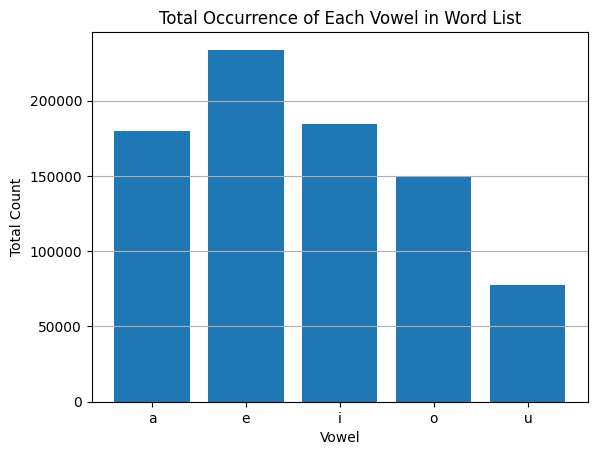

In [86]:
vowel_distribution = {'a': 0, 'e': 0, 'i': 0 , 'o': 0, 'u': 0}

for i in df:
    count = Counter(i)
    for v in vowel_set:
        vowel_distribution[v] += count[v]

plt.bar(vowel_distribution.keys(), vowel_distribution.values())
plt.title("Total Occurrence of Each Vowel in Word List")
plt.xlabel("Vowel")
plt.ylabel("Total Count")
plt.grid(axis='y')
plt.show()

### Statistically the order of guesses for vowel must be e,i,a,o,u 

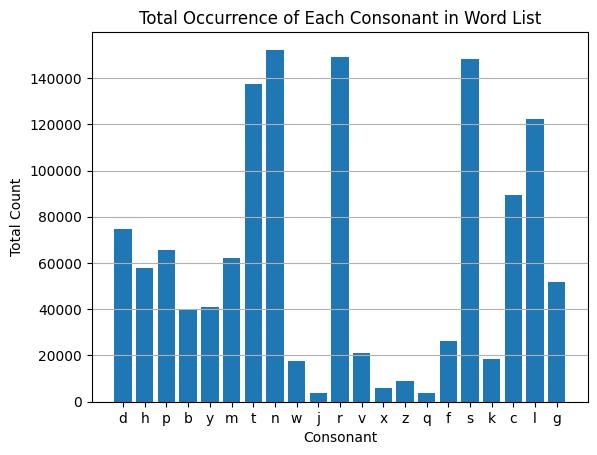

In [88]:
consonant_set = set(string.ascii_lowercase) - vowel_set

consonant_distribution = {c: 0 for c in consonant_set}

for i in df:
    count = Counter(i)
    for c in consonant_set:
        consonant_distribution[c] += count[c]

plt.bar(consonant_distribution.keys(), consonant_distribution.values())
plt.title("Total Occurrence of Each Consonant in Word List")
plt.xlabel("Consonant")
plt.ylabel("Total Count")
plt.grid(axis='y')
plt.show()

### Statistically the first guesses from consonants must be n,r,s,t,l,c... and so on

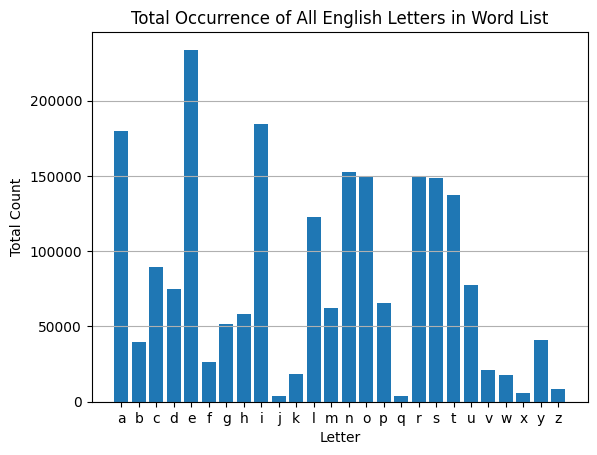

In [92]:
total_letter_distribution = {**vowel_distribution, **consonant_distribution}

total_letter_distribution = dict(sorted(total_letter_distribution.items()))

plt.bar(total_letter_distribution.keys(), total_letter_distribution.values())
plt.title("Total Occurrence of All English Letters in Word List")
plt.xlabel("Letter")
plt.ylabel("Total Count")
plt.grid(axis='y')
plt.show()

In [94]:
sorted_letter_distribution = dict(sorted(total_letter_distribution.items(), key=lambda item: item[1], reverse=True))

sorted_letter_distribution.keys()

dict_keys(['e', 'i', 'a', 'n', 'o', 'r', 's', 't', 'l', 'c', 'u', 'd', 'p', 'm', 'h', 'g', 'y', 'b', 'f', 'v', 'k', 'w', 'z', 'x', 'q', 'j'])

### The ideal order for guesses should be as above for the words from training set, but we also have a dependency on length of words as discussed below.

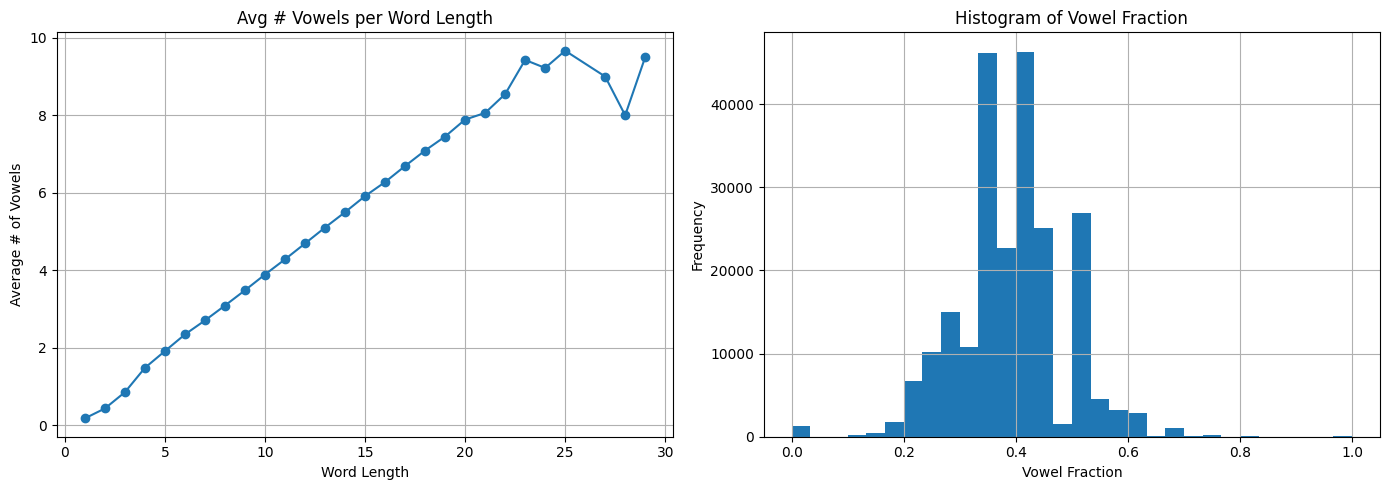

In [96]:
df_stats = pd.DataFrame({'length': lengths, 'vowels': vowels})
grouped = df_stats.groupby('length').mean()

vowel_frac = vowels / lengths

fig, axes = plt.subplots(ncols=2, figsize=(14, 5))

axes[0].plot(grouped.index, grouped['vowels'], marker='o')
axes[0].set_title("Avg # Vowels per Word Length")
axes[0].set_xlabel("Word Length")
axes[0].set_ylabel("Average # of Vowels")
axes[0].grid(True)

axes[1].hist(vowel_frac,bins=30)
axes[1].set_title("Histogram of Vowel Fraction")
axes[1].set_xlabel("Vowel Fraction")
axes[1].set_ylabel("Frequency")
axes[1].grid(True)

plt.tight_layout()
plt.show()

### The number of vowels in a word increases with the word's length, suggesting a directly proportional relationship.

### And from the distribution above we can conclude that most fraction  The maximum number of vowel with significant frequency observed is approximately half the length of the word, hence guessing vowel after that won't be a good choice

In [100]:
max_length = max(lengths)

letter_freq_by_length = {letter: [0] * max_length for letter in string.ascii_lowercase}

for word in df:
    word = word.lower()
    length = len(word)
    if 1 <= length <= max_length:
        count = Counter(word)
        for letter in count:
            if letter in letter_freq_by_length:
                letter_freq_by_length[letter][length - 1] += count[letter]

freq_df = pd.DataFrame(letter_freq_by_length).transpose()
freq_df.columns = list(range(1, max_length + 1))
freq_df.index.name = "Letter"
freq_df.columns.name = "Length of Word"

ranked_columns = {}

for length in range(1, max_length + 1):
    letter_series = freq_df[length]
    non_zero = letter_series[letter_series > 0]
    sorted_letters = non_zero.sort_values(ascending=False).index.tolist()
    ranked_columns[length] = sorted_letters

max_ranks = max(len(lst) for lst in ranked_columns.values())
final_ranked = {}

for rank in range(max_ranks):
    row = []
    for length in range(1, max_length + 1):
        if rank < len(ranked_columns[length]):
            row.append(ranked_columns[length][rank])
        else:
            row.append("")
    final_ranked[f"#{rank+1}"] = row

ranked_df = pd.DataFrame.from_dict(final_ranked, orient='index')
ranked_df.columns = list(range(1, max_length + 1))
ranked_df.columns.name = "Length of Word"
ranked_df.index.name = "Rank"
pd.set_option('display.max_columns', None)
ranked_df

Length of Word,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29
Rank,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
#1,c,c,a,a,a,e,e,e,e,e,e,e,e,e,i,e,e,i,i,e,o,o,i,o,e,,o,a,i
#2,m,w,s,e,e,a,a,a,i,i,i,i,i,i,e,i,i,e,e,o,i,i,o,i,a,,r,l,t
#3,w,d,c,o,s,i,i,i,a,a,a,a,n,n,n,n,o,o,o,i,e,e,e,e,i,,c,b,e
#4,v,h,e,s,o,r,r,s,s,r,n,n,a,a,a,o,n,n,a,a,t,n,t,r,s,,e,c,n
#5,s,r,o,i,r,s,s,r,r,n,r,o,o,o,o,s,a,s,n,t,a,r,l,t,n,,t,e,r
#6,r,e,i,r,i,o,n,n,o,o,o,r,t,t,t,a,s,t,t,n,s,t,a,a,r,,y,f,l
#7,p,i,t,l,l,n,o,o,n,s,t,t,r,s,s,t,t,a,s,r,r,l,c,l,l,,i,g,m
#8,o,a,m,t,n,l,l,t,t,t,s,s,s,r,r,r,r,r,r,l,n,s,r,c,h,,s,h,y
#9,k,u,d,n,t,t,t,l,l,l,l,l,l,l,l,l,l,l,l,s,l,a,n,h,p,,d,i,h


### This is the refined version of distribution of letters, the table shows the distribution/occurence of each letter in every bucket of lengths, using this information we know which letters to guess first for a fix length of a word.

In [103]:
def get_optimal_guess_order(words):
    guessed = []
    remaining_words = words.copy()
    
    while True:
        letter_counter = Counter()

        for word in remaining_words:
            unique_letters = set(word)
            for l in unique_letters:
                if l not in guessed:
                    letter_counter[l] += 1

        if not letter_counter:
            break

        next_guess = letter_counter.most_common(1)[0][0]
        guessed.append(next_guess)

        remaining_words = [w for w in remaining_words if next_guess not in w]

    return ''.join(guessed)

In [105]:
optimal_guesses_by_length = {}

for length in range(1, 30):
    word_subset = [w.lower() for w in df if len(w) == length]
    
    if word_subset:
        optimal_guesses_by_length[length] = get_optimal_guess_order(word_subset)
    else:
        optimal_guesses_by_length[length] = ""

optimal_table = pd.DataFrame.from_dict(optimal_guesses_by_length, orient='index', columns=["Optimal calling order"])
optimal_table.index.name = "Number of letters"
optimal_table

,Optimal calling order
Number of letters,
1,cdefghijkmoprsvwy
2,cdirwhabnesotlkfvuypgjmxz
3,aseocitmdulprnbhfzkqx
4,aeoiusltdncmhbk
5,aeoiuysrmp
6,eaoiuysb
7,eaiouyp
8,eaioup
9,eiaou


### This is the final table showing the order of guessing the letters for each bucket of lengths, we can use this table for making our guesses.

*****

### We won't be using any of the above stats rather we will refer to global word statistics and a dynamic approach to guessing letters

****

In [870]:
# Letter frequency prior (ETAOIN SHRDLU)
ETAOIN = "etaoinshrdlcumwfgypbvkjxqz"
PRIOR = {ch: (26 - i) for i, ch in enumerate(ETAOIN)}
PRIOR_MIN, PRIOR_MAX = min(PRIOR.values()), max(PRIOR.values())

def normalize(x, lo, hi):
    if hi <= lo:
        return 0.0
    return (x - lo) / (hi - lo)

In [1009]:
class HangmanAPI(object):
    def __init__(self, access_token=None, session=None, timeout=None):
        self.hangman_url = self.determine_hangman_url()
        self.access_token = access_token
        self.session = session or requests.Session()
        self.timeout = timeout
        self.guessed_letters = []
        
        full_dictionary_location = "words_250000_train.txt"
        self.full_dictionary = self.build_dictionary(full_dictionary_location)        
        self.full_dictionary_common_letter_sorted = collections.Counter("".join(self.full_dictionary)).most_common()
        
        self.current_dictionary = []
        
    @staticmethod
    def determine_hangman_url():
        links = ['https://trexsim.com']

        data = {link: 0 for link in links}

        for link in links:

            requests.get(link)

            for i in range(10):
                s = time.time()
                requests.get(link)
                data[link] = time.time() - s

        link = sorted(data.items(), key=lambda x: x[1])[0][0]
        link += '/trexsim/hangman'
        return link
        
    def guess(self, word):  # word input example: "_ p p _ e "
        # --- normalize mask & sets ---
        mask = word.replace(" ", "").lower()            # "__pp_e"
        present = set(ch for ch in mask if ch != "_")   # letters already on board
        wrong = set(self.guessed_letters) - present
        tries_left = 6 - len(wrong)
    
        # --- filter current plausible dictionary with strict Hangman constraints ---
        new_dictionary = []
        for w in self.current_dictionary:
            if len(w) != len(mask):
                continue
            ok = True
            for i, m in enumerate(mask):
                if m == "_":
                    # underscores cannot hide letters already revealed anywhere,
                    # and cannot be a previously wrong letter
                    if w[i] in present or w[i] in wrong:
                        ok = False; break
                else:
                    if w[i] != m:
                        ok = False; break
            # also forbid any wrong letter anywhere in the word
            if ok and any(ch in wrong for ch in w):
                ok = False
            if ok:
                new_dictionary.append(w)
    
        # overwrite the class' plausible set
        self.current_dictionary = new_dictionary
    
        # letters we’re allowed to guess
        alphabet = "abcdefghijklmnopqrstuvwxyz"
        avail = [ch for ch in alphabet if ch not in self.guessed_letters]
        if not avail:
            return "e"  # extreme fallback
    
        n = len(new_dictionary)
        unknown_pos = [i for i, m in enumerate(mask) if m == "_"]
        blanks = len(unknown_pos)
    
        # --- First-move override: pristine board (no reveals, 6 lives) ---
        if tries_left == 6 and not present:
            from collections import Counter
            L = len(mask)
    
            if not hasattr(self, "_any_by_len"):
                self._any_by_len = {}        # {L: Counter(letter->#words-with-letter)}
                self._len_count  = Counter() # {L: #words of length L}
                for w_ in self.full_dictionary:
                    lw = len(w_)
                    self._len_count[lw] += 1
                    seen = set(w_)
                    cL = self._any_by_len.setdefault(lw, Counter())
                    for ch_ in seen:
                        cL[ch_] += 1
    
            poolL = [w for w in self.current_dictionary if len(w) == L] or \
                    [w for w in self.full_dictionary if len(w) == L]
            if poolL:
                has_counts = {ch: 0 for ch in avail}
                pos_counts = [Counter() for _ in range(L)]
                for w in poolL:
                    s = set(w)
                    for ch in has_counts:
                        if ch in s:
                            has_counts[ch] += 1
                    for i, ch in enumerate(w):
                        pos_counts[i][ch] += 1
    
                # helpers
                def norm_prior(ch):
                    lo, hi = PRIOR_MIN, PRIOR_MAX
                    return 0.0 if hi <= lo else (PRIOR.get(ch, lo) - lo)/(hi - lo)
    
                nL = float(len(poolL))
                totalL = max(1, self._len_count.get(L, len(poolL)))
                anyL = self._any_by_len.get(L, {})
    
                scores = []
                for ch in avail:
                    p_any_len = anyL.get(ch, 0) / totalL          # P(ch anywhere | length L)
                    p = has_counts[ch] / nL                       # same but from the pool slice
                    split = 1.0 - max(p, 1.0 - p)                 # entropy-ish split
                    pos_fill = sum(pos_counts[i].get(ch, 0) for i in range(L)) / (nL * max(1, L))
    
                    # light biases: favor e>a; damp o/u on medium lengths (4–9)
                    e_bonus = 0.02 if ch == 'e' else 0.0
                    a_bonus = 0.01 if ch == 'a' else 0.0
                    o_pen   = 0.02 if (ch == 'o' and 4 <= L <= 9) else 0.0
                    u_pen   = 0.01 if (ch == 'u' and 4 <= L <= 9) else 0.0
    
                    sc = (0.60*split +
                          0.22*pos_fill +
                          0.10*norm_prior(ch) +
                          0.08*p_any_len +
                          e_bonus + a_bonus - o_pen - u_pen)
                    scores.append((sc, ch))
    
                scores.sort(reverse=True)
                top_sc, top_ch = scores[0]
    
                # NEW: soft prefer 'e' when it's close to the top
                e_sc = next((sc for sc, ch in scores if ch == 'e'), None)
                if e_sc is not None and top_ch != 'e' and (top_sc - e_sc) < 0.05:
                    return 'e'
    
                # very short words—prefer 'o' if close (to/of/no/so)
                if L <= 3:
                    o_sc = next((sc for sc, ch in scores if ch == 'o'), None)
                    if o_sc is not None and (top_sc - o_sc) < 0.06:
                        return 'o'
    
                # existing: if 'o' barely wins, take the runner-up
                if scores and scores[0][1] == 'o' and len(scores) > 1 and (scores[0][0] - scores[1][0]) < 0.03:
                    return scores[1][1]
                return scores[0][1]
    
        # --- candidate-driven stats (preferred) ---
        has_counts = {ch: 0 for ch in avail}    # how many candidate words contain ch at least once
        pos_hits   = {ch: 0 for ch in avail}    # matches at unknown positions
    
        if n > 0:
            for w in new_dictionary:
                s = set(w)
                for ch in avail:
                    if ch in s:
                        has_counts[ch] += 1
                for i in unknown_pos:
                    ch_i = w[i]
                    if ch_i in pos_hits:
                        pos_hits[ch_i] += 1
    
            # p(hit anywhere in the word)
            p_hit = {ch: has_counts[ch] / n for ch in avail}
            # multiplicity-aware: expected # of blanks filled (no /blanks)
            fill_prob = {ch: (pos_hits[ch] / n) for ch in avail}
        else:
            # fallback priors from provided training dictionary (allowed)
            L = len(mask)
            total = 0
            pos_counts = [dict() for _ in range(L)]
            any_counts = {ch: 0 for ch in avail}
    
            for w in self.full_dictionary:
                if len(w) != L: continue
                total += 1
                seen = set()
                for i, ch in enumerate(w):
                    pos_counts[i][ch] = pos_counts[i].get(ch, 0) + 1
                    seen.add(ch)
                for ch in seen:
                    if ch in any_counts:
                        any_counts[ch] += 1
    
            if total > 0:
                p_hit = {ch: any_counts[ch] / total for ch in avail}
                # multiplicity-aware fallback (no /blanks)
                sfill = {}
                for ch in avail:
                    s = 0.0
                    for i in unknown_pos:
                        s += pos_counts[i].get(ch, 0) / total
                    sfill[ch] = s
                fill_prob = sfill
            else:
                p_hit = {ch: 0.0 for ch in avail}
                fill_prob = {ch: 0.0 for ch in avail}
    
        # ---------------------------
        # Helper: ensure bidirectional MKN-4g exists (build once)
        # ---------------------------
        def ensure_mkn(both=True):
            if both:
                if hasattr(self, "_prob_left") and hasattr(self, "_prob_right"):
                    return
            else:
                if hasattr(self, "_prob_left"):
                    return
    
            from collections import defaultdict, Counter
    
            # LEFT chain (always needed)
            if not hasattr(self, "_c1L"):
                self._c1L   = Counter()
                self._c2L   = defaultdict(Counter)   # (c,)           -> d
                self._c3L   = defaultdict(Counter)   # (b,c)          -> d
                self._c4L   = defaultdict(Counter)   # (a,b,c)        -> d
    
                for w in self.full_dictionary:
                    w = w.strip().lower()
                    if not w or (not w.isalpha()):
                        continue
                    s = "^^^" + w + "$$$"
                    Ls = len(s)
                    for i in range(Ls):
                        ch = s[i]
                        self._c1L[ch] += 1
                        if i >= 1: self._c2L[(s[i-1],)][ch] += 1
                        if i >= 2: self._c3L[(s[i-2], s[i-1])][ch] += 1
                        if i >= 3: self._c4L[(s[i-3], s[i-2], s[i-1])][ch] += 1
    
                self._sum2L = {ctx: sum(cnt.values()) for ctx, cnt in self._c2L.items()}
                self._sum3L = {ctx: sum(cnt.values()) for ctx, cnt in self._c3L.items()}
                self._sum4L = {ctx: sum(cnt.values()) for ctx, cnt in self._c4L.items()}
    
                # continuation counts (base)
                contL = Counter()
                for (c,), nxts in self._c2L.items():
                    for d, ct in nxts.items():
                        if ct > 0: contL[d] += 1
                self._contL = contL
                self._contL_total = sum(contL.values()) or 1
    
                # discounts
                def _disc(counts_by_ctx):
                    n1 = n2 = n3 = n4p = 0
                    for _ctx, cnts in counts_by_ctx.items():
                        for _d, c in cnts.items():
                            if c == 1: n1 += 1
                            elif c == 2: n2 += 1
                            elif c == 3: n3 += 1
                            elif c >= 4: n4p += 1
                    if n1 == 0 or n2 == 0: return (0.75, 0.75, 0.75)
                    Y = n1 / (n1 + 2.0 * n2)
                    clamp = lambda x: max(0.0, min(1.0, x))
                    D1 = 1.0 - 2.0 * Y * (n2 / max(1, n1))
                    D2 = 2.0 - 3.0 * Y * (n3 / max(1, n2))
                    D3 = 0.75 if (n3 == 0 or n4p == 0) else (3.0 - 4.0 * Y * (n4p / max(1, n3)))
                    return (clamp(D1), clamp(D2), clamp(D3))
    
                self._D2L = _disc(self._c2L)
                self._D3L = _disc(self._c3L)
                self._D4L = _disc(self._c4L)
    
                def _p_uni_left(d):
                    if d not in alphabet: return 0.0
                    return self._contL.get(d, 0.0) / self._contL_total
    
                def _kn(next_counts, total_sum, discounts, backoff_fn, d):
                    if total_sum <= 0: return backoff_fn(d)
                    D1, D2, D3 = discounts
                    c = next_counts.get(d, 0)
                    N1 = N2 = N3p = 0
                    for _sym, ct in next_counts.items():
                        if ct == 1: N1 += 1
                        elif ct == 2: N2 += 1
                        elif ct >= 3: N3p += 1
                    if   c == 0: left = 0.0
                    elif c == 1: left = max(c - D1, 0.0) / total_sum
                    elif c == 2: left = max(c - D2, 0.0) / total_sum
                    else:        left = max(c - D3, 0.0) / total_sum
                    lam = (D1*N1 + D2*N2 + D3*N3p) / total_sum
                    return left + lam * backoff_fn(d)
    
                def _p_bg_left(c1, d):
                    cnts = self._c2L.get((c1,), {}); total = self._sum2L.get((c1,), 0)
                    return _kn(cnts, total, self._D2L, _p_uni_left, d)
    
                def _p_tg_left(b, c, d):
                    cnts = self._c3L.get((b, c), {}); total = self._sum3L.get((b, c), 0)
                    return _kn(cnts, total, self._D3L, lambda x: _p_bg_left(c, x), d)
    
                def _p_4g_left(a, b, c, d):
                    cnts = self._c4L.get((a, b, c), {}); total = self._sum4L.get((a, b, c), 0)
                    return _kn(cnts, total, self._D4L, lambda x: _p_tg_left(b, c, x), d)
    
                def _prob_left(d, p3, p2, p1):
                    if p1 is None: return _p_uni_left(d)
                    if p2 is None: return _p_bg_left(p1, d)
                    if p3 is None: return _p_tg_left(p2, p1, d)
                    return _p_4g_left(p3, p2, p1, d)
    
                self._prob_left = _prob_left  # left ready
    
            # RIGHT chain (only if both=True)
            if both and not hasattr(self, "_prob_right"):
                from collections import defaultdict as _D, Counter as _C
                self._c1R   = _C()
                self._c2R   = _D(Counter)   # (n1,)      -> c
                self._c3R   = _D(Counter)   # (n1,n2)    -> c
                self._c4R   = _D(Counter)   # (n1,n2,n3) -> c
    
                for w in self.full_dictionary:
                    w = w.strip().lower()
                    if not w or (not w.isalpha()):
                        continue
                    s = "^^^" + w + "$$$"
                    Ls = len(s)
                    for i in range(Ls):
                        ch = s[i]
                        self._c1R[ch] += 1
                        if i + 1 < Ls: self._c2R[(s[i+1],)][ch] += 1
                        if i + 2 < Ls: self._c3R[(s[i+1], s[i+2])][ch] += 1
                        if i + 3 < Ls: self._c4R[(s[i+1], s[i+2], s[i+3])][ch] += 1
    
                self._sum2R = {ctx: sum(cnt.values()) for ctx, cnt in self._c2R.items()}
                self._sum3R = {ctx: sum(cnt.values()) for ctx, cnt in self._c3R.items()}
                self._sum4R = {ctx: sum(cnt.values()) for ctx, cnt in self._c4R.items()}
    
                contR = _C()
                for (n1,), prevs in self._c2R.items():
                    for c, ct in prevs.items():
                        if ct > 0: contR[c] += 1
                self._contR = contR
                self._contR_total = sum(contR.values()) or 1
    
                def _p_uni_right(d):
                    if d not in alphabet: return 0.0
                    return self._contR.get(d, 0.0) / self._contR_total
    
                def _disc(counts_by_ctx):
                    n1 = n2 = n3 = n4p = 0
                    for _ctx, cnts in counts_by_ctx.items():
                        for _d, c in cnts.items():
                            if c == 1: n1 += 1
                            elif c == 2: n2 += 1
                            elif c == 3: n3 += 1
                            elif c >= 4: n4p += 1
                    if n1 == 0 or n2 == 0: return (0.75, 0.75, 0.75)
                    Y = n1 / (n1 + 2.0 * n2)
                    clamp = lambda x: max(0.0, min(1.0, x))
                    D1 = 1.0 - 2.0 * Y * (n2 / max(1, n1))
                    D2 = 2.0 - 3.0 * Y * (n3 / max(1, n2))
                    D3 = 0.75 if (n3 == 0 or n4p == 0) else (3.0 - 4.0 * Y * (n4p / max(1, n3)))
                    return (clamp(D1), clamp(D2), clamp(D3))
    
                self._D2R = _disc(self._c2R)
                self._D3R = _disc(self._c3R)
                self._D4R = _disc(self._c4R)
    
                def _kn(next_counts, total_sum, discounts, backoff_fn, d):
                    if total_sum <= 0: return backoff_fn(d)
                    D1, D2, D3 = discounts
                    c = next_counts.get(d, 0)
                    N1 = N2 = N3p = 0
                    for _sym, ct in next_counts.items():
                        if ct == 1: N1 += 1
                        elif ct == 2: N2 += 1
                        elif ct >= 3: N3p += 1
                    if   c == 0: left = 0.0
                    elif c == 1: left = max(c - D1, 0.0) / total_sum
                    elif c == 2: left = max(c - D2, 0.0) / total_sum
                    else:        left = max(c - D3, 0.0) / total_sum
                    lam = (D1*N1 + D2*N2 + D3*N3p) / total_sum
                    return left + lam * backoff_fn(d)
    
                def _p_bg_right(n1, d):
                    cnts = self._c2R.get((n1,), {}); total = self._sum2R.get((n1,), 0)
                    return _kn(cnts, total, self._D2R, _p_uni_right, d)
                def _p_tg_right(n1, n2, d):
                    cnts = self._c3R.get((n1, n2), {}); total = self._sum3R.get((n1, n2), 0)
                    return _kn(cnts, total, self._D3R, lambda x: _p_bg_right(n1, x), d)
                def _p_4g_right(n1, n2, n3, d):
                    cnts = self._c4R.get((n1, n2, n3), {}); total = self._sum4R.get((n1, n2, n3), 0)
                    return _kn(cnts, total, self._D4R, lambda x: _p_tg_right(n1, n2, x), d)
    
                def _prob_right(d, n1, n2, n3):
                    if n1 is None: return _p_uni_right(d)
                    if n2 is None: return _p_bg_right(n1, d)
                    if n3 is None: return _p_tg_right(n1, n2, d)
                    return _p_4g_right(n1, n2, n3, d)
    
                self._prob_right = _prob_right  # right ready
    
        # ---------------------------------
        # LM fill score for ALL stages (not just endgame)
        # ---------------------------------
        ensure_mkn(both=True)
        lm_fill = {ch: 0.0 for ch in avail}
        Lm = len(mask)
        for i in unknown_pos:
            p3 = mask[i-3] if i-3 >= 0 and mask[i-3] != "_" else ("^" if i-3 < 0 else None)
            p2 = mask[i-2] if i-2 >= 0 and mask[i-2] != "_" else ("^" if i-2 < 0 else None)
            p1 = mask[i-1] if i-1 >= 0 and mask[i-1] != "_" else ("^" if i-1 < 0 else None)
            n1 = mask[i+1] if i+1 < Lm and mask[i+1] != "_" else ("$" if i+1 >= Lm else None)
            n2 = mask[i+2] if i+2 < Lm and mask[i+2] != "_" else ("$" if i+2 >= Lm else None)
            n3 = mask[i+3] if i+3 < Lm and mask[i+3] != "_" else ("$" if i+3 >= Lm else None)
            for ch in avail:
                pL = self._prob_left(ch, p3, p2, p1)
                pR = self._prob_right(ch, n1, n2, n3)
                lm_fill[ch] += pL * pR


        # --- suffix booster (common English tails) ---
        suffixes = ("ing","ed","er","ly","tion","ness","less","ment","able","ous","ize","ist","ism","ish","ful")
        tail_boost = {ch: 0.0 for ch in avail}
        
        for suf in suffixes:
            k = len(suf)
            if Lm < k:
                continue
            tail = mask[-k:]
        
            # need at least one blank in the tail
            if "_" not in tail:
                continue
        
            # quick feasibility: only boost if at least one candidate could end with this suffix
            if n > 0 and n <= 20000:
                # new_dictionary already respects the mask, so endswith is enough
                if not any(w.endswith(suf) for w in new_dictionary):
                    continue
        
            # require at least one position already agreeing with the suffix (so it's not random)
            agree = sum(1 for mch, sch in zip(tail, suf) if mch == sch)
            if agree == 0:
                continue
        
            # reward letters that would fill remaining tail blanks
            for mch, sch in zip(tail, suf):
                if mch == "_" and sch in avail:
                    tail_boost[sch] += 1.0
        
        # normalize & fold into lm_fill (gentle)
        if tail_boost and max(tail_boost.values()) > 0:
            mx = max(tail_boost.values())
            for ch in tail_boost:
                lm_fill[ch] += 0.15 * (tail_boost[ch] / mx)

        
        # one-blank solver (choose letter maximizing pL*pR at the gap)
        if blanks == 1:
            i = unknown_pos[0]
            p3 = mask[i-3] if i-3 >= 0 and mask[i-3] != "_" else ("^" if i-3 < 0 else None)
            p2 = mask[i-2] if i-2 >= 0 and mask[i-2] != "_" else ("^" if i-2 < 0 else None)
            p1 = mask[i-1] if i-1 >= 0 and mask[i-1] != "_" else ("^" if i-1 < 0 else None)
            n1 = mask[i+1] if i+1 < Lm and mask[i+1] != "_" else ("$" if i+1 >= Lm else None)
            n2 = mask[i+2] if i+2 < Lm and mask[i+2] != "_" else ("$" if i+2 >= Lm else None)
            n3 = mask[i+3] if i+3 < Lm and mask[i+3] != "_" else ("$" if i+3 >= Lm else None)
            best_ch, best_sc = None, -1.0
            for ch in avail:
                sc = self._prob_left(ch, p3, p2, p1) * self._prob_right(ch, n1, n2, n3)
                if sc > best_sc:
                    best_sc, best_ch = sc, ch
            return best_ch
    
        # ---------------------------
        # Endgame override (finisher) — heavier LM
        # ---------------------------
        if blanks <= 2 or tries_left <= 2:
            vals = list(lm_fill.values())
            lo, hi = (min(vals), max(vals)) if vals else (0.0, 1.0)
            nz = (lambda v: 0.0) if hi <= lo else (lambda v: (v - lo) / (hi - lo))
    
            best_ch, best_sc = None, -1.0
            for ch in avail:
                sc = 0.8 * fill_prob.get(ch, 0.0) + 0.2 * nz(lm_fill.get(ch, 0.0))  # 0.80/0.20
                if sc > best_sc:
                    best_sc, best_ch = sc, ch
            return best_ch
    
        # ---------------------------------
        # Regular (mid-game) hybrid scoring
        # (unchanged below; uses new fill_prob implicitly)
        # ---------------------------------
        split_score = {ch: 0.0 for ch in avail}
        var_score   = {ch: 0.0 for ch in avail}
        pat_split   = {ch: 0.0 for ch in avail}
        word_mass   = {ch: 0.0 for ch in avail}
    
        if n > 0:
            # classical split/var
            for ch in avail:
                have = has_counts[ch]
                have_not = n - have
                worst = max(have, have_not)
                p = have / n
                split_score[ch] = 1.0 - (worst / max(1, n))  # bigger is better
                var_score[ch]   = 2.0 * p * (1.0 - p)        # peaked at 0.5
    
            # pattern-aware split (expected remaining size)
            CAP_PAT = 40000
            if n <= CAP_PAT and blanks > 0:
                from collections import Counter
                idx_map = {pos: b for b, pos in enumerate(unknown_pos)}
                for ch in avail:
                    if has_counts[ch] == 0:
                        pat_split[ch] = 0.0
                        continue
                    patterns = Counter()
                    miss = 0
                    for w in new_dictionary:
                        if ch in w:
                            m = 0
                            for pos in unknown_pos:
                                if w[pos] == ch:
                                    m |= (1 << idx_map[pos])
                            patterns[m] += 1
                        else:
                            miss += 1
                    sum_sq = sum(c*c for c in patterns.values())
                    E_remain = (sum_sq + miss*miss) / n
                    pat_split[ch] = max(0.0, 1.0 - (E_remain / max(1, n)))
    
            # word-mass over left LM
            CAP_MASS = 20000
            if blanks > 0 and n <= CAP_MASS:
                if not hasattr(self, "_wm_cache"): self._wm_cache = {}
                mass = {ch: 0.0 for ch in avail}
                for w in new_dictionary:
                    letters_in_unknowns = set(w[pos] for pos in unknown_pos)
                    if w in self._wm_cache:
                        logp = self._wm_cache[w]
                    else:
                        ctx = ["^", "^", "^"]; logp = 0.0
                        for ch in w:
                            p = self._prob_left(ch, ctx[0], ctx[1], ctx[2])
                            if p <= 0.0: p = 1e-12
                            logp += math.log(p)
                            ctx = [ctx[1], ctx[2], ch]
                        self._wm_cache[w] = logp
                    wp = math.exp(logp)
                    for ch in letters_in_unknowns:
                        if ch in mass:
                            mass[ch] += wp
                # normalize to [0,1]
                vals = list(mass.values())
                if vals:
                    lo, hi = min(vals), max(vals)
                    if hi > lo:
                        for ch in mass:
                            word_mass[ch] = (mass[ch] - lo) / (hi - lo)
    
        # tiny global frequency prior from your precomputed list
        global_freq = {ch: 0 for ch in avail}
        try:
            freq_list = getattr(self, "full_dictionary_common_letter_sorted", [])
            mx = float(freq_list[0][1]) if freq_list else 1.0
            d = dict(freq_list)
            for ch in avail:
                global_freq[ch] = (d.get(ch, 0) / mx) if mx > 0 else 0.0
        except Exception:
            pass
    
        vowels = set("aeiou")
        board_blank = (len(present) == 0)
    
        if n > 30000:
            w_split, w_var, w_hit, w_pos, w_prior, w_pat, w_mass, w_lm = 0.12, 0.04, 0.28, 0.20, 0.02, 0.04, 0.06, 0.24
        elif n > 5000:
            w_split, w_var, w_hit, w_pos, w_prior, w_pat, w_mass, w_lm = 0.18, 0.06, 0.25, 0.22, 0.02, 0.08, 0.08, 0.21
        else:
            w_split, w_var, w_hit, w_pos, w_prior, w_pat, w_mass, w_lm = 0.24, 0.06, 0.22, 0.24, 0.02, 0.10, 0.08, 0.14
    
        if tries_left <= 2:
            w_hit += 0.15; w_split -= 0.06; w_pat += 0.04; w_lm += 0.03
        elif tries_left == 3:
            w_hit += 0.08; w_split -= 0.03; w_lm += 0.02
    
        if board_blank:
            # gentle vowel bias only on pristine boards (after first move handled)
            for ch in avail:
                if ch in vowels:
                    fill_prob[ch] *= 1.05
                    p_hit[ch]     *= 1.05
    
        # normalize LM fill to [0,1]
        vals = list(lm_fill.values())
        if vals:
            lo, hi = min(vals), max(vals)
            if hi > lo:
                for ch in lm_fill:
                    lm_fill[ch] = (lm_fill[ch] - lo) / (hi - lo)
            else:
                for ch in lm_fill:
                    lm_fill[ch] = 0.0
    
        best_ch, best_score = None, -1.0
        for ch in avail:
            score = (
                w_split * split_score.get(ch, 0.0) +
                w_var   * var_score.get(ch, 0.0)   +
                w_hit   * p_hit.get(ch, 0.0)       +
                w_pos   * fill_prob.get(ch, 0.0)   +
                w_prior * global_freq.get(ch, 0.0) +
                w_pat   * pat_split.get(ch, 0.0)   +
                w_mass  * word_mass.get(ch, 0.0)   +
                w_lm    * lm_fill.get(ch, 0.0)
            )
            if score > best_score:
                best_score, best_ch = score, ch
    
        # safety fallback: original global frequency order
        if best_ch is None:
            for letter, _cnt in getattr(self, "full_dictionary_common_letter_sorted", []):
                if letter not in self.guessed_letters:
                    best_ch = letter; break
            if best_ch is None:
                for ch in alphabet:
                    if ch not in self.guessed_letters:
                        best_ch = ch; break
    
        return best_ch


    ##########################################################
    # You'll likely not need to modify any of the code below #
    ##########################################################
    
    def build_dictionary(self, dictionary_file_location):
        text_file = open(dictionary_file_location,"r")
        full_dictionary = text_file.read().splitlines()
        text_file.close()
        return full_dictionary
                
    def start_game(self, practice=True, verbose=True):
        # reset guessed letters to empty set and current plausible dictionary to the full dictionary
        self.guessed_letters = []
        self.current_dictionary = self.full_dictionary
                         
        response = self.request("/new_game", {"practice":practice})
        if response.get('status')=="approved":
            game_id = response.get('game_id')
            word = response.get('word')
            tries_remains = response.get('tries_remains')
            if verbose:
                print("Successfully start a new game! Game ID: {0}. # of tries remaining: {1}. Word: {2}.".format(game_id, tries_remains, word))
            while tries_remains>0:
                # get guessed letter from user code
                guess_letter = self.guess(word)
                    
                # append guessed letter to guessed letters field in hangman object
                self.guessed_letters.append(guess_letter)
                if verbose:
                    print("Guessing letter: {0}".format(guess_letter))
                    
                try:    
                    res = self.request("/guess_letter", {"request":"guess_letter", "game_id":game_id, "letter":guess_letter})
                except HangmanAPIError:
                    print('HangmanAPIError exception caught on request.')
                    continue
                except Exception as e:
                    print('Other exception caught on request.')
                    raise e
               
                if verbose:
                    print("Sever response: {0}".format(res))
                status = res.get('status')
                tries_remains = res.get('tries_remains')
                if status=="success":
                    if verbose:
                        print("Successfully finished game: {0}".format(game_id))
                    return True
                elif status=="failed":
                    reason = res.get('reason', '# of tries exceeded!')
                    if verbose:
                        print("Failed game: {0}. Because of: {1}".format(game_id, reason))
                    return False
                elif status=="ongoing":
                    word = res.get('word')
        else:
            if verbose:
                print("Failed to start a new game")
        return status=="success"
        
    def my_status(self):
        return self.request("/my_status", {})
    
    def request(
            self, path, args=None, post_args=None, method=None):
        if args is None:
            args = dict()
        if post_args is not None:
            method = "POST"

        # Add `access_token` to post_args or args if it has not already been
        if self.access_token:
            if post_args and "access_token" not in post_args:
                post_args["access_token"] = self.access_token
            elif "access_token" not in args:
                args["access_token"] = self.access_token

        time.sleep(0.2)

        num_retry, time_sleep = 50, 2
        for it in range(num_retry):
            try:
                response = self.session.request(
                    method or "GET",
                    self.hangman_url + path,
                    timeout=self.timeout,
                    params=args,
                    data=post_args,
                    verify=False
                )
                break
            except requests.HTTPError as e:
                response = json.loads(e.read())
                raise HangmanAPIError(response)
            except requests.exceptions.SSLError as e:
                if it + 1 == num_retry:
                    raise
                time.sleep(time_sleep)

        headers = response.headers
        if 'json' in headers['content-type']:
            result = response.json()
        elif "access_token" in parse_qs(response.text):
            query_str = parse_qs(response.text)
            if "access_token" in query_str:
                result = {"access_token": query_str["access_token"][0]}
                if "expires" in query_str:
                    result["expires"] = query_str["expires"][0]
            else:
                raise HangmanAPIError(response.json())
        else:
            raise HangmanAPIError('Maintype was not text, or querystring')

        if result and isinstance(result, dict) and result.get("error"):
            raise HangmanAPIError(result)
        return result
    
class HangmanAPIError(Exception):
    def __init__(self, result):
        self.result = result
        self.code = None
        try:
            self.type = result["error_code"]
        except (KeyError, TypeError):
            self.type = ""

        try:
            self.message = result["error_description"]
        except (KeyError, TypeError):
            try:
                self.message = result["error"]["message"]
                self.code = result["error"].get("code")
                if not self.type:
                    self.type = result["error"].get("type", "")
            except (KeyError, TypeError):
                try:
                    self.message = result["error_msg"]
                except (KeyError, TypeError):
                    self.message = result

        Exception.__init__(self, self.message)

# API Usage Examples

## To start a new game:
1. Make sure you have implemented your own "guess" method.
2. Use the access_token that we sent you to create your HangmanAPI object. 
3. Start a game by calling "start_game" method.
4. If you wish to test your function without being recorded, set "practice" parameter to 1.
5. Note: You have a rate limit of 20 new games per minute. DO NOT start more than 20 new games within one minute.

In [1011]:
api = HangmanAPI(access_token="c142fc835ac6ba249b479b78d2352c", timeout=2000)

## Playing practice games:
You can use the command below to play up to 100,000 practice games.

In [1019]:
api.start_game(practice=1,verbose=True)

[total_practice_runs,total_recorded_runs,total_recorded_successes,total_practice_successes] = api.my_status() # Get my game stats: (# of tries, # of wins)
practice_success_rate = total_practice_successes / total_practice_runs
print('run %d practice games out of an allotted 100,000. practice success rate so far = %.3f' % (total_practice_runs, practice_success_rate))

Successfully start a new game! Game ID: 41ebe0e1ea92. # of tries remaining: 6. Word: _ _ _ _ _ _ _ _ _ .
Guessing letter: t
Sever response: {'game_id': '41ebe0e1ea92', 'status': 'ongoing', 'tries_remains': 5, 'word': '_ _ _ _ _ _ _ _ _ '}
Guessing letter: e
Sever response: {'game_id': '41ebe0e1ea92', 'status': 'ongoing', 'tries_remains': 5, 'word': '_ _ _ _ _ _ e _ _ '}
Guessing letter: s
Sever response: {'game_id': '41ebe0e1ea92', 'status': 'ongoing', 'tries_remains': 5, 'word': '_ _ _ _ _ _ e _ s '}
Guessing letter: r
Sever response: {'game_id': '41ebe0e1ea92', 'status': 'ongoing', 'tries_remains': 5, 'word': '_ _ _ _ _ r e r s '}
Guessing letter: u
Sever response: {'game_id': '41ebe0e1ea92', 'status': 'ongoing', 'tries_remains': 5, 'word': '_ _ _ u _ r e r s '}
Guessing letter: i
Sever response: {'game_id': '41ebe0e1ea92', 'status': 'ongoing', 'tries_remains': 5, 'word': '_ _ _ u i r e r s '}
Guessing letter: a
Sever response: {'game_id': '41ebe0e1ea92', 'status': 'ongoing', 'tries_

In [1024]:
### 

Game   0: SUCCESS | word=unproverbial
Game   1: SUCCESS | word=distend
Game   2: SUCCESS | word=dunstable
Game   3: SUCCESS | word=blousier
Game   4: FAIL    | word=s___ng_ia_
Game   5: SUCCESS | word=seline
Game   6: FAIL    | word=be__s_
Game   7: SUCCESS | word=monopteroid
Game   8: FAIL    | word=an__dric
Game   9: FAIL    | word=she__hs
Game  10: SUCCESS | word=unamortization
Game  11: SUCCESS | word=saggering
Game  12: FAIL    | word=nono__ensi_e
Game  13: SUCCESS | word=menticulture
Game  14: FAIL    | word=_itman
Game  15: FAIL    | word=___llo__orous
Game  16: FAIL    | word=o__icialt_
Game  17: FAIL    | word=_e_ia__in
Game  18: SUCCESS | word=stepless
Game  19: FAIL    | word=na__ly
Game  20: SUCCESS | word=contraception
Game  21: FAIL    | word=larg_ett_
Game  22: SUCCESS | word=pledging
Game  23: FAIL    | word=e__inom_s
Game  24: SUCCESS | word=supervention
Game  25: FAIL    | word=_rere___al
Game  26: FAIL    | word=full_outhed
Game  27: SUCCESS | word=underspring
Game  

## Playing recorded games:
Please finalize your code prior to running the cell below. Once this code executes once successfully your submission will be finalized. Our system will not allow you to rerun any additional games.

Please note that it is expected that after you successfully run this block of code that subsequent runs will result in the error message "Your account has been deactivated".

Once you've run this section of the code your submission is complete. Please send us your source code via email.

In [1028]:
for i in range(1000):
    print('Playing ', i, ' th game')
    # Uncomment the following line to execute your final runs. Do not do this until you are satisfied with your submission
    api.start_game(practice=0,verbose=False)
    
    # DO NOT REMOVE as otherwise the server may lock you out for too high frequency of requests
    time.sleep(0.5)

Playing  0  th game
Playing  1  th game
Playing  2  th game
Playing  3  th game
Playing  4  th game
Playing  5  th game
Playing  6  th game
Playing  7  th game
Playing  8  th game
Playing  9  th game
Playing  10  th game
Playing  11  th game
Playing  12  th game
Playing  13  th game
Playing  14  th game
Playing  15  th game
Playing  16  th game
Playing  17  th game
Playing  18  th game
Playing  19  th game
Playing  20  th game
Playing  21  th game
Playing  22  th game
Playing  23  th game
Playing  24  th game
Playing  25  th game
Playing  26  th game
Playing  27  th game
Playing  28  th game
Playing  29  th game
Playing  30  th game
Playing  31  th game
Playing  32  th game
Playing  33  th game
Playing  34  th game
Playing  35  th game
Playing  36  th game
Playing  37  th game
Playing  38  th game
Playing  39  th game
Playing  40  th game
Playing  41  th game
Playing  42  th game
Playing  43  th game
Playing  44  th game
Playing  45  th game
Playing  46  th game
Playing  47  th game
Pl

HangmanAPIError: {'error': 'You have reached 1000 of games', 'status': 'denied'}

## To check your game statistics
1. Simply use "my_status" method.
2. Returns your total number of games, and number of wins.

In [1031]:
[total_practice_runs,total_recorded_runs,total_recorded_successes,total_practice_successes] = api.my_status() # Get my game stats: (# of tries, # of wins)
success_rate = total_recorded_successes/total_recorded_runs
print('overall success rate = %.3f' % success_rate)

overall success rate = 0.445
